## CS365 Final Project

### Libraries

In [ ]:
import os
import random, re, spacy
import torch
import pandas as pd
import numpy as np
from datasets import load_metric
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Data Processing

In [ ]:
#cleaning
def text_cleaner(text):
    #remove words between ()
    cleaned_string = ""
    paren_depth = 0
    for c in text:
        if c == '(':
            paren_depth += 1
        elif c == ')' and paren_depth:
            paren_depth -= 1
        elif paren_depth == 0:
            cleaned_string += c

    newString = cleaned_string.lower()
    newString = re.sub('"','', newString)  
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 

    tokens = newString.split()
    long_words = [i for i in tokens if len(i) > 1]

    return (" ".join(long_words)).strip()


In [3]:
#training data
paper_data_lstm = []
abstract_data_lstm = []

vocab_dict = {}

#File
paper_file_path = [
    "../dataset/paper/Comp_Ling_paper_{}.txt".format(i) for i in range(1, 101)
]
abstract_file_path = [
    "../dataset/abstract/abstract_{}.txt".format(i) for i in range(1, 101)
]

for i in range(len(paper_file_path)):
    with open(paper_file_path[i], "r") as f:
        paper = f.read()

    with open(abstract_file_path[i], "r") as f:
        abstract = f.read()
    
    cleaned_paper = text_cleaner(paper)
    cleaned_abstract = text_cleaner(abstract)

    #Tokenization
    nlp = spacy.load("en_core_web_sm")

    paper_tokens = [tok.text for tok in nlp(cleaned_paper)]
    abstract_tokens = ['<sos>'] + [tok.text for tok in nlp(cleaned_abstract)] + ['<eos>']

    for token in paper_tokens:
        if token not in vocab_dict:
            vocab_dict[token] = len(vocab_dict)
    for token in abstract_tokens:
        if token not in vocab_dict:
            vocab_dict[token] = len(vocab_dict)
            
    paper_data_lstm.append(paper_tokens)
    abstract_data_lstm.append(abstract_tokens)


In [4]:
test_paper = '../dataset/test/paper_ex.txt'
with open(test_paper, "r") as f:
    test_text = f.read()

cleaned_example = text_cleaner(test_text)
test_tokens_original = word_tokenize(cleaned_example)

for token in test_tokens_original:
        if token not in vocab_dict:
            vocab_dict[token] = len(vocab_dict)
test_tokens = test_tokens_original[:2132]
test_vocab = {token: idx for idx, token in enumerate(set(test_tokens))}
test_vocab_size  = len(test_vocab)
vocab_dict.update(test_vocab)


In [5]:
vocab_size = []
paper_input = []
abstract_input = []
for i in range(len(paper_data_lstm)):
    paper_vocab = {token: idx for idx, token in enumerate(set(paper_data_lstm[i]))}
    abstract_vocab = {token: idx for idx, token in enumerate(set(abstract_data_lstm[i]))}

    vocab_size.append([len(paper_vocab), len(abstract_vocab)])

    paper_indices = [paper_vocab[token] for token in paper_data_lstm[i]]
    abstract_indices = [abstract_vocab[token] for token in abstract_data_lstm[i]]

    paper_indices_tensor = torch.tensor(paper_indices)
    abstract_indices_tensor = torch.tensor(abstract_indices)

    paper_input.append(paper_indices_tensor)
    abstract_input.append(abstract_indices_tensor)

### LSTM

In [6]:
class MyDataset(Dataset):
    def __init__(self, paper_data, abstract_data):
        self.paper_data = paper_data
        self.abstract_data = abstract_data

    def __len__(self):
        return len(self.paper_data)

    def __getitem__(self, idx):
        return self.paper_data[idx], self.abstract_data[idx]

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        # first input to the decoder is the <sos> tokens
        input = trg[:,0]
        
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:,t,:] = output
            # decide if we will use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            # if teacher forcing, use actual next token as next input. If not, use predicted token
            input = trg[:,t] if teacher_force else top1
        
        return outputs


In [7]:
def validate(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # Disable gradient computation
        for paper_data, abstract_data in val_loader:
            paper_data, abstract_data = paper_data.to(device), abstract_data.to(device)
            output = model(paper_data, abstract_data)
            output_dim = output.shape[-1]
            output = output[1:].reshape(-1, output_dim)
            target = abstract_data[1:].contiguous().view(-1)
            loss = criterion(output, target)
            total_loss += loss.item()
    return total_loss / len(val_loader)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs  = 40
batch_size = 512

def my_collate_fn(batch):
    paper_batch, abstract_batch = zip(*batch)
    paper_padded = pad_sequence(paper_batch, batch_first=True, padding_value=0)
    abstract_padded = pad_sequence(abstract_batch, batch_first=True, padding_value=0)
    return paper_padded, abstract_padded

paper_train, paper_val, abstract_train, abstract_val = train_test_split(
    paper_input, abstract_input, test_size=0.2, random_state=42
)

train_dataset = MyDataset(paper_train, abstract_train)
val_dataset = MyDataset(paper_val, abstract_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=my_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=my_collate_fn)

INPUT_DIM = 3000
OUTPUT_DIM = 500
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(encoder, decoder, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

best_val_loss = float('inf')

In [ ]:
#Training
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (paper_data, abstract_data) in enumerate(train_loader):
        paper_data, abstract_data = paper_data.to(device), abstract_data.to(device)
        optimizer.zero_grad()

        decoder_input = abstract_data[:, :-1]
        output = model(paper_data, decoder_input)
        output_dim = output.shape[-1]
        output = output.reshape(-1, output_dim)

        #masking
        target = abstract_data[:, 1:].reshape(-1) 
        mask = target != 0

        output = output[mask]
        target = target[mask]
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = validate(model, val_loader, criterion, device)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

    if avg_val_loss < best_val_loss: 
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'lstm_summarization_model_ver2.pth')
        print(f"Model saved at Epoch {epoch+1} with validation loss {avg_val_loss}")


In [9]:
def generate_summary(model, tokens, paper_vocab, device):
    text_indices = [paper_vocab[token] for token in tokens]
    paper_data_tensor = torch.tensor(text_indices).unsqueeze(0).to(device)
    model.eval()
    
    with torch.no_grad():
        #seq2seq
        hidden, cell = model.encoder(paper_data_tensor)
        trg = torch.tensor([paper_vocab['<sos>']]).to(device)

        generated_tokens = []


        for _ in range(146): #max summary length
            output, hidden, cell = model.decoder(trg, hidden, cell)
            output_probs = F.softmax(output, dim=1)
            predicted_token = torch.multinomial(output_probs, 1).item()
            generated_tokens.append(predicted_token)

            if predicted_token == paper_vocab['<eos>']:
                break

            trg = torch.tensor([predicted_token]).to(device)

    return generated_tokens

model = Seq2Seq(encoder, decoder, device)
model.load_state_dict(torch.load('../Models/lstm_summarization_model_best.pth', map_location=device))
model.eval()

summary_tokens = generate_summary(model, test_tokens, vocab_dict, device)

def get_key_from_value(dictionary, target_value):
    for key, value in dictionary.items():
        if value == target_value:
            return key
    return ' '

summary_text = ''
for token in summary_tokens:
    word  = get_key_from_value(vocab_dict, token)
    summary_text += word
    summary_text += ' '

print("Generated Summary:")
print(summary_text)

Generated Summary:
era as are world   languages to extractive provide incentivized significant or exist success leveled severe speed faithfulness questions perform address its freely instance generative reasons formally future could newly incentivized leave construct still brought task deep often shed goes tracted years conjunction intertextual to systems manner consider motivating november covering part ranging closely across improve dialogue   overlap descriptions system therefore hybrid generative mean context analysis across variety beginning yet success response availability small thousands was same extractive consider lacking across independent may where pretrained source album   pipeline with inference feasibility unsupervised evaluation released hallucinate sources george sources sources instead responses yet view respect sources about album per issues across hybrid lacking quantitatively investigated released ystem statistics workload   neural more dialogue ignoring capturing 

### Evaluation

In [10]:
def calculate_rouge_scores(predictions, references):
    rouge = load_metric("rouge")
    results = rouge.compute(predictions=predictions, references=references)
    return results

#test data
test_abstract = '../dataset/test/abstract_ex.txt'

with open(test_paper, "r") as f:
    test_abs = f.read()

cleaned_example_abstract = text_cleaner(test_abs)

# example summary and reference summary
generated_summary = summary_text
reference_summary = cleaned_example_abstract

GPT_summary = 'The text discusses the importance of readability in leveled reading materials for language learners and introduces Automatic Readability Assessment (ARA) as a solution. Initially, readability assessment relied on formulas based on text statistics, but later evolved to include features mined from text and utilized in traditional machine learning models. Deep learning models, particularly pre-trained language models (PLMs) like BERT, have also been effective in ARA, although they face challenges due to small datasets and the complexity of long passages. The text proposes integrating linguistic features with PLMs to address these challenges and presents experimental results demonstrating significant accuracy improvements, particularly on long passages. It also introduces a new dataset, RAZ, derived from leveled books of RAZ-Kid, to enhance research practicality. Key findings include the effectiveness of linguistic features in improving PLM accuracy, diminishing returns with larger datasets, and the unsuitability of the Newsela dataset for ARA.'
GPT_summary_long = 'The text discusses the importance of readability assessment in language learning materials and proposes Automatic Readability Assessment (ARA) as a solution to meet the demand for leveled reading materials. Initially, readability formulas were designed based on statistical features of text, but later, researchers incorporated morphological, lexical, syntactic, and discourse features into traditional machine learning models and deep learning models like RNNs and pre-trained language models (PLMs) such as BERT. However, challenges arise due to the scarcity of large-scale ARA datasets and the complexity of long passages, which may exceed capacity of PLMs. To address these challenges, linguistic features are integrated with PLMs to improve accuracy, particularly on longer passages. Additionally, a new dataset called RAZ is constructed from leveled books of RAZ-Kid, enhancing the practicality of research. The study investigates how linguistic features enhance performance of PLMs, especially concerning passage length, concluding that linguistic features significantly improve accuracy, especially on longer passages, but their impact diminishes with larger dataset sizes. It also suggests that the Newsela dataset might not be suitable for ARA.'
GPT_summary_full = 'The text introduces the concept of Automatic Readability Assessment (ARA), which aims to assess the readability level of texts automatically, crucial for language learners. Initially, formulas were designed based on text statistics, later researchers mined various linguistic features to use with traditional machine learning models and deep learning models like RNN-based and pre-trained language models (PLMs). However, challenges exist due to small datasets and the complexity of long passages. To address these issues, the authors propose integrating linguistic features with PLMs. They conducted experiments and found that even simple linguistic features significantly improve accuracy of PLM on small datasets, particularly on long passages. However, the effectiveness of these features diminishes with larger datasets. Additionally, they introduce a new dataset called RAZ and analyze its impact. Further analysis reveals that linguistic features are more effective on smaller datasets, especially for long passages. They also suggest that the Newsela dataset might not be suitable for ARA due to overlaps between simplification and readability levels. Overall, the study sheds light on how linguistic features enhance performance ofPLM in ARA, especially concerning passage length, dataset size, and dataset suitability.'
# Calculate ROUGE scores
rouge_scores = calculate_rouge_scores([generated_summary], [reference_summary])
rouge_scores_gpt = calculate_rouge_scores([GPT_summary], [reference_summary])
rouge_scores_gpt_long = calculate_rouge_scores([GPT_summary_long], [reference_summary])
rouge_scores_gpt_full = calculate_rouge_scores([GPT_summary_full], [reference_summary])

# Print ROUGE scores
print("Generated Summary")
for key, value in rouge_scores.items():
    print(f"{key}: {value.mid.precision:.4f} (Precision), {value.mid.recall:.4f} (Recall), {value.mid.fmeasure:.4f} (F1 Score)")
print("GPT Summary")
for key, value in rouge_scores_gpt.items():
    print(f"{key}: {value.mid.precision:.4f} (Precision), {value.mid.recall:.4f} (Recall), {value.mid.fmeasure:.4f} (F1 Score)")
print()
print("GPT Summary Long")
for key, value in rouge_scores_gpt.items():
    print(f"{key}: {value.mid.precision:.4f} (Precision), {value.mid.recall:.4f} (Recall), {value.mid.fmeasure:.4f} (F1 Score)")
print("GPT Summary Full")
for key, value in rouge_scores_gpt_full.items():
    print(f"{key}: {value.mid.precision:.4f} (Precision), {value.mid.recall:.4f} (Recall), {value.mid.fmeasure:.4f} (F1 Score)")


/var/folders/ng/flg7zcgn5kv09hpndc61cjx00000gn/T/ipykernel_54413/1671614913.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")
/Users/seungmincho/anaconda3/lib/python3.11/site-packages/datasets/load.py:756: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/Users/seungmincho/anaconda3/lib/python3.11/site-packages/datasets/load.py:756: FutureWarning: The repository for rouge contains custom code which mu

Generated Summary
rouge1: 0.1972 (Precision), 0.0435 (Recall), 0.0713 (F1 Score)
rouge2: 0.0000 (Precision), 0.0000 (Recall), 0.0000 (F1 Score)
rougeL: 0.0915 (Precision), 0.0202 (Recall), 0.0331 (F1 Score)
rougeLsum: 0.0915 (Precision), 0.0202 (Recall), 0.0331 (F1 Score)
GPT Summary
rouge1: 0.6959 (Precision), 0.1602 (Recall), 0.2604 (F1 Score)
rouge2: 0.2449 (Precision), 0.0561 (Recall), 0.0913 (F1 Score)
rougeL: 0.4932 (Precision), 0.1135 (Recall), 0.1846 (F1 Score)
rougeLsum: 0.4932 (Precision), 0.1135 (Recall), 0.1846 (F1 Score)

GPT Summary Long
rouge1: 0.6959 (Precision), 0.1602 (Recall), 0.2604 (F1 Score)
rouge2: 0.2449 (Precision), 0.0561 (Recall), 0.0913 (F1 Score)
rougeL: 0.4932 (Precision), 0.1135 (Recall), 0.1846 (F1 Score)
rougeLsum: 0.4932 (Precision), 0.1135 (Recall), 0.1846 (F1 Score)
GPT Summary Full
rouge1: 0.7059 (Precision), 0.2053 (Recall), 0.3181 (F1 Score)
rouge2: 0.2419 (Precision), 0.0701 (Recall), 0.1087 (F1 Score)
rougeL: 0.4225 (Precision), 0.1229 (Recall),

/Users/seungmincho/anaconda3/lib/python3.11/site-packages/datasets/load.py:756: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [11]:
summary_50 = 'across model relationship   help was formulas conduit modeling   pipeline   statements implicit studies attempts ranging history example uniform explicit systems introduce which neural instead faithfulness languages sources variety outside formally communication known known allows evaluate models   develop evaluating was outside still texts did informative freely   years'
summary_100 = 'again of known   highly processing session consider or promotion assess validate where such if attribute develop obtained statistical nlp al attributable ebrahimi prior applied representative eurasia   newsela language language sources though generation cases sources bert   <sos> step human system relatively between documents pretrained though the lacking proposed key generative documents generation consisting accurate cases examine publicly extra he dropped acts communication may contains thousands imperatives gpt responses analyze length imperatives nlg   assess formulas consider performance develop   generative translation attribution step severe often instead or availability natural required these system harrison summarization lexical shared translation addition'
#150 words but 137 words because of <eos>
summary_150 = 'response prior annotations mainly era evaluation length informative expertise errors nuanced annotations who brought ensure allows contains including indirect three simple diversity   hundreds notice accurate lacking translation close notice elementary instance separate years evaluation time pretrained addition annotators advanced place vast dialogue light   very eurasia explicature length source popular imperatives annotations lexical hallucination generating formal applicable he annotated elementary addition article total underlying shows he cost george support newsela length defined complex unimorph known formally gap   framework step newly cases across dropped harrison without americas era inclined output overlap newsela set inten <sos> perform non or generating accurate morphologi highly close   eurasia known computer first models wonderwall yet attempts released recently designers against take sequence instead example addition important key significant yet corroboration often cases problems shows extra present diverse remain consisting relationship according place applicable issues'
summary_200 = 'ystem well besides new release crowdsourcing were extractive extra by independent inference step successfully channel analyze dropped hallucination released imperative across known strict word consider solo applied level problems vast dialogue explicitly dialogue evidence   promotion vast respect evaluation accurate dropped indirect attribution mean portion yet covering systems word richer released information performance respect grounded their advanced human requires requires attribute support different or models obtained https yet   summarization its generating challenging one generates faithfulness solid starting light most pretrained texts may hallucination dialogue demand present demand system attribution use was simple formally have shows explicitly source ebrahimi questions printed documents time representation need neural consider lexical thousands translation demonstrated database translation rated xue generative attributable responses issues conjunction framework discuss work underlying sources hallucinate further implement popular training popular performance   attributable exist eas george explicature but would need attribute gram   communication attempts ensure according families learn attribution advanced recently score sequence between hundreds annotations framework   related lacking close article discuss future portion uniform communicators challenge formulas consisting considerable google standard lacking guaran they texts appendices released https spanning languages separate ever capturing newsela given standard model including important generative platforms accurate information score word improve'
summary_250 = 'sources   how manner user feasible   resources cases natural difficult guaran when development demand these stage or extended discuss album evaluation think question computer   demand al pipeline world their   goes well diversity imperative if generative length years step errors step   allows generation sequence ystem   proposed very generation underlying often questions crowdsourcing   training demonstrated george important part covering availability three solo hallucinate consisting again framework learn statistical issues shed were eas starting consider instead word obtained instead use overlap achieved considerable stipulating challenging formulas considerable if or challenging supported framework claims bridge advanced set vast imperatives validate dialogue motivating dropped investigated generation few end sequence attribution followed neural though at topics lated independent interaction according leveled user contains important framework example or strict remain lexical   with demand variety ones properly key cases questions develop their greater acts blurry mean framework across hallucination most promotion on eurasia relatively hallucination system families often known generative vast key descriptions he expertise capturing   developed level consider acts processing translation resolving their designers system question respect   respect generation level develop goes or responses performance with possible word provides george generative advanced would dropped tasks focused sources covering length years sequence separate mean required types promotion where ystem implement deep sequence according summarization statistical questions was pretrained outside inclined translation user manner   key   millions question its documents machine elementary   strict their accurate popular pretrained families were lexical consider lexical required consider relatively promotion universal natural'
#'digital overlap motivating problems analyze mean ratings support attributable nlp families appendices in independent output consisting data diversity purposefully recently extracting annotated responses obtained often experiments making cases hallucinate indirect very achieve descriptions performance making system predominantly required closely multilingual years in demand recently translation these often outside is transfer challenge sufficient to palm grounded lacking standard types texts key newly with simple particularly generate particularly acts tasks users word they eurasian models ystem       key xue goals promotion applied considers done approaches generates cost mean such music summarization could reducing extended example wonderwall strict explicitly ever diverse thousands systems length ones level though morphologi demand lexical   explicit publicly done generative palm issues newsela definition notice designers handling can performance performance such demand were issues eurasia support require pretrained help unsupervised evaluating entertaining dropped strict ranging translation sequence across generate support challenge sequence   texts families speed xlm ever most dropped implement variety ever known summarization resource levels album performance experiments ystem gram user difficult evaluating developed attribute to annotated documents could after which or eas ser extracting designers required generate ystem with relatively their evaluate extracting newsela accurate george reliability generates beginning severe generating known lacking question imperatives ystem systems conjunction ones quantitatively in learn rely ystem americas attribution challenges required related newsela lacking attribution given accurate promotion inclined addition particularly support morphologi predominantly thousands popular possible levels attempts more grounded eurasian newsela evaluating leave more translation pretrained discuss nli question known considers world length notice'
summary_300 = 'significant uniform speed designers sequence have leave ones against severe ebrahimi place   https printed auto mix references bert annotated channel basis breakthrough deal generation followed portion   <sos> transfer example model   this another   need abstractive projection these printed errors having this blurry one for lated conduit breakthrough close issues evaluation consisting model pretrained communicators generative   future achieve attributed notice have consisting evaluation informative   pretrained accurate vast lacking morphologi pretrained neural across who feasible known hallucinate consisting important promotion respect experiments sources relatively released pretrained level statistical grounded key rely required models these ser contradicts levels quantitatively strict user mean machine light platforms lacking length ystem sequence experiments   questions sequence time set ser work training attributable often attribution article challenges outside easier shows acts leveled developed across dropped capturing   topics if closely responses pretrained newsela often pretrained references transfer claims in information newsela   pretrained ensure often summarization pretrained having generates attribution lev gram suited machine well shed considers cases availability hallucinate known digital use further summarization feasibility communicative summarization more severe documents years capturing availability respect proposed between dependencies sources word   further mix further deal relatively texts attribution annotations he instance training relationship ser considers results unimorph learn translation generation music xlm if different extra severe acts close without dropped points was across experiments goes challenging nli consisting auto harrison natural was attribute systems hallucination music standard models boundaries sufficient nuanced across dialogue generative complex   challenging new motivating portion   sources generation neural designers lev   standard length set evaluation length ranging recently models reliability hallucination music cases available annotator generative   lacking sources word article lexical closely accurate consisting newsela unclear considerable families promotion variety experiments digital are which ystem incentivized annotation but if   issues bert github when learn leave across developed cases complex text discrepancy generates illustrative standard history such concise documents cases limited significant far channel questions best part studies translation empirically hundreds   palm instance accurate limited auto nlp generative annotator even era generation designers attempted unimorph questions mean models popular first systems bridge google motivating text can natural evaluation uniform ensure era claims severe translation first advanced harrison richer questions ascertain relatively   brought uniform explicitly develop generative cases newsela overlap consisting lexical natural in translation propositions underlying generative best resolving consisting support models learn develop done across evidence pertaining george required length challenge three '



rouge_scores_50 = calculate_rouge_scores([summary_50], [reference_summary])
rouge_scores_100 = calculate_rouge_scores([summary_100], [reference_summary])
rouge_scores_150 = calculate_rouge_scores([summary_150], [reference_summary])
rouge_scores_200 = calculate_rouge_scores([summary_200], [reference_summary])
rouge_scores_250 = calculate_rouge_scores([summary_250], [reference_summary])
rouge_scores_383 = calculate_rouge_scores([summary_300], [reference_summary])

print("length 50")
for key, value in rouge_scores_50.items():
    print(f"{key}: {value.mid.precision:.4f} (Precision), {value.mid.recall:.4f} (Recall), {value.mid.fmeasure:.4f} (F1 Score)")
print("length 100")
for key, value in rouge_scores_100.items():
    print(f"{key}: {value.mid.precision:.4f} (Precision), {value.mid.recall:.4f} (Recall), {value.mid.fmeasure:.4f} (F1 Score)")
print("length 150")
for key, value in rouge_scores_150.items():
    print(f"{key}: {value.mid.precision:.4f} (Precision), {value.mid.recall:.4f} (Recall), {value.mid.fmeasure:.4f} (F1 Score)")
print("length 200")
for key, value in rouge_scores_200.items():
    print(f"{key}: {value.mid.precision:.4f} (Precision), {value.mid.recall:.4f} (Recall), {value.mid.fmeasure:.4f} (F1 Score)")
print("length 250")
for key, value in rouge_scores_250.items():
    print(f"{key}: {value.mid.precision:.4f} (Precision), {value.mid.recall:.4f} (Recall), {value.mid.fmeasure:.4f} (F1 Score)")
print("length 383")
for key, value in rouge_scores_383.items():
    print(f"{key}: {value.mid.precision:.4f} (Precision), {value.mid.recall:.4f} (Recall), {value.mid.fmeasure:.4f} (F1 Score)")

/Users/seungmincho/anaconda3/lib/python3.11/site-packages/datasets/load.py:756: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/Users/seungmincho/anaconda3/lib/python3.11/site-packages/datasets/load.py:756: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to

length 50
rouge1: 0.1111 (Precision), 0.0078 (Recall), 0.0145 (F1 Score)
rouge2: 0.0000 (Precision), 0.0000 (Recall), 0.0000 (F1 Score)
rougeL: 0.0889 (Precision), 0.0062 (Recall), 0.0116 (F1 Score)
rougeLsum: 0.0889 (Precision), 0.0062 (Recall), 0.0116 (F1 Score)
length 100
rouge1: 0.2316 (Precision), 0.0342 (Recall), 0.0596 (F1 Score)
rouge2: 0.0000 (Precision), 0.0000 (Recall), 0.0000 (F1 Score)
rougeL: 0.0947 (Precision), 0.0140 (Recall), 0.0244 (F1 Score)
rougeLsum: 0.0947 (Precision), 0.0140 (Recall), 0.0244 (F1 Score)
length 150
rouge1: 0.1533 (Precision), 0.0327 (Recall), 0.0538 (F1 Score)
rouge2: 0.0000 (Precision), 0.0000 (Recall), 0.0000 (F1 Score)
rougeL: 0.0657 (Precision), 0.0140 (Recall), 0.0231 (F1 Score)
rougeLsum: 0.0657 (Precision), 0.0140 (Recall), 0.0231 (F1 Score)
length 200
rouge1: 0.2051 (Precision), 0.0622 (Recall), 0.0955 (F1 Score)
rouge2: 0.0000 (Precision), 0.0000 (Recall), 0.0000 (F1 Score)
rougeL: 0.0564 (Precision), 0.0171 (Recall), 0.0263 (F1 Score)
rou

/Users/seungmincho/anaconda3/lib/python3.11/site-packages/datasets/load.py:756: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


### Analysis

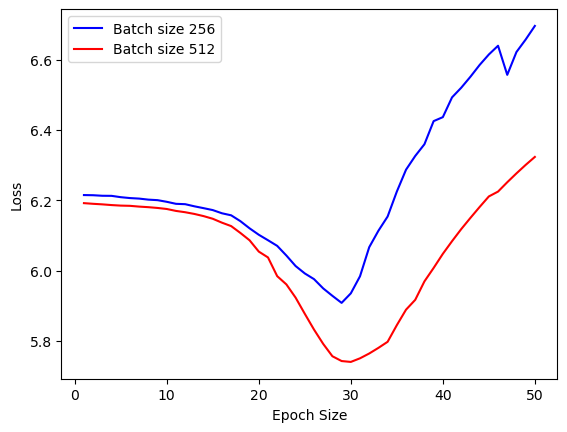

In [12]:
#Batch size

Epoch_list = [x for x in range(1,51)]

#Val loss with different batch size
batch_256 = [
    6.21519136428833, 6.214724063873291, 6.2131805419921875, 6.212952613830566, 6.209162712097168,
    6.206629276275635, 6.205130100250244, 6.202194690704346, 6.200684547424316, 6.196010112762451,
    6.190285682678223, 6.189253330230713, 6.183204174041748, 6.1779584884643555, 6.172473430633545,
    6.163381099700928, 6.157585144042969, 6.140994071960449, 6.1206207275390625, 6.1023268699646,
    6.086754322052002, 6.0707502365112305, 6.043216228485107, 6.013437747955322, 5.99238920211792,
    5.97622013092041, 5.949806213378906, 5.928738594055176, 5.908694267272949, 5.935765266418457,
    5.984397888183594, 6.066954135894775, 6.1137919425964355, 6.154195785522461, 6.2250142097473145,
    6.287292003631592, 6.326328277587891, 6.359646797180176, 6.425377368927002, 6.436675071716309,
    6.492900371551514, 6.520322799682617, 6.55157995223999, 6.585103511810303, 6.6147894859313965,
    6.639636039733887, 6.556909084320068, 6.6218414306640625, 6.657279014587402, 6.69598913192749
]

batch_512 = [
    6.192203044891357, 6.190314769744873, 6.188745498657227, 6.186720371246338, 6.1852126121521,
    6.184574604034424, 6.182371139526367, 6.180751323699951, 6.178526401519775, 6.175586700439453,
    6.170106887817383, 6.166388988494873, 6.161497116088867, 6.1553568840026855, 6.147785663604736,
    6.136656284332275, 6.12692403793335, 6.1074748039245605, 6.086592197418213, 6.054471492767334,
    6.03786039352417, 5.98466157913208, 5.961151123046875, 5.9235968589782715, 5.87762975692749,
    5.8328328132629395, 5.792041778564453, 5.756974220275879, 5.743349552154541, 5.740853786468506,
    5.7511372566223145, 5.764797687530518, 5.780789852142334, 5.798075199127197, 5.845339298248291,
    5.889374732971191, 5.917327404022217, 5.969769477844238, 6.008025169372559, 6.048081398010254,
    6.084068298339844, 6.118463039398193, 6.150363445281982, 6.181362628936768, 6.211269855499268,
    6.225076198577881, 6.251622200012207, 6.2768402099609375, 6.300896167755127, 6.32359504699707
]


plt.plot(Epoch_list, batch_256, color='b', label='Batch size 256') 
plt.plot(Epoch_list, batch_512, color='r', label='Batch size 512') 
plt.xlabel('Epoch Size')
plt.ylabel('Loss')
plt.legend()
plt.show()

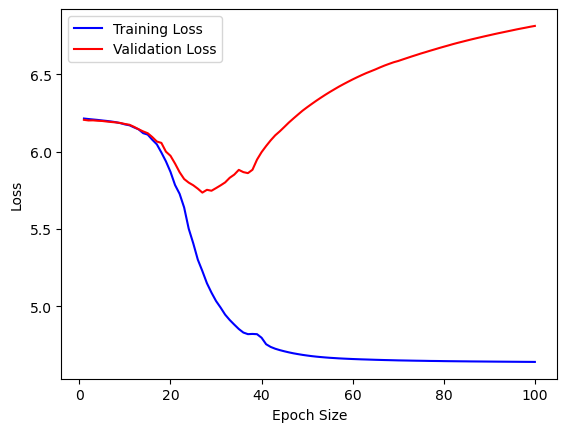

In [13]:
#Training Loss and Validication Loss

Epoch_list = [x for x in range(1,101)]

#Training Loss and Validication Loss
Train_Loss = [
    6.214159965515137, 6.210912704467773, 6.208003997802734, 6.205183982849121, 6.201728820800781,
    6.198591709136963, 6.194957256317139, 6.190441131591797, 6.184260845184326, 6.176113128662109,
    6.170393943786621, 6.156774520874023, 6.144139766693115, 6.119602680206299, 6.110172748565674,
    6.077239036560059, 6.047423839569092, 5.994516372680664, 5.937108516693115, 5.86926794052124,
    5.784258842468262, 5.727391242980957, 5.638644695281982, 5.501824855804443, 5.407016754150391,
    5.301606178283691, 5.227789878845215, 5.149066925048828, 5.088285446166992, 5.034235954284668,
    4.991771697998047, 4.945988178253174, 4.911490440368652, 4.881614685058594, 4.853086948394775,
    4.830193996429443, 4.819818019866943, 4.821188926696777, 4.819588661193848, 4.796626091003418,
    4.754570960998535, 4.737119674682617, 4.72547721862793, 4.716501712799072, 4.708911418914795,
    4.701999187469482, 4.695833206176758, 4.690613269805908, 4.68573522567749, 4.681559085845947,
    4.677704334259033, 4.674439430236816, 4.671639919281006, 4.669119358062744, 4.666852951049805,
    4.6650519371032715, 4.663132667541504, 4.66164493560791, 4.660282611846924, 4.658963203430176,
    4.657881736755371, 4.656778812408447, 4.655910491943359, 4.654923915863037, 4.653969764709473,
    4.653156280517578, 4.6523213386535645, 4.651662826538086, 4.650928020477295, 4.650139808654785,
    4.649632930755615, 4.6491169929504395, 4.648513317108154, 4.648006439208984, 4.647567272186279,
    4.647125720977783, 4.646546840667725, 4.646265983581543, 4.645937442779541, 4.645402908325195,
    4.645041465759277, 4.644761085510254, 4.644413471221924, 4.644091606140137, 4.643832206726074,
    4.643423557281494, 4.643212795257568, 4.642974853515625, 4.6427178382873535, 4.642472743988037,
    4.642209529876709, 4.641979217529297, 4.64173698425293, 4.641538143157959, 4.641255855560303,
    4.641091346740723, 4.6408185958862305, 4.640604019165039, 4.640435695648193, 4.640209197998047
]
Val_Loss  = [
    6.205747604370117, 6.201779365539551, 6.202437400817871, 6.199795246124268, 6.198395252227783,
    6.194817066192627, 6.191720962524414, 6.189075946807861, 6.185368061065674, 6.178873062133789,
    6.173830986022949, 6.160407543182373, 6.144918441772461, 6.130884170532227, 6.119250297546387,
    6.094554424285889, 6.065544605255127, 6.05655574798584, 5.9999895095825195, 5.973208904266357,
    5.9230217933654785, 5.86717414855957, 5.8229169845581055, 5.7997307777404785, 5.782531261444092,
    5.7604804039001465, 5.735124588012695, 5.753185749053955, 5.7472147941589355, 5.764242649078369,
    5.781994342803955, 5.80108118057251, 5.8308634757995605, 5.851444244384766, 5.882193088531494,
    5.86764669418335, 5.861028671264648, 5.882836818695068, 5.948583602905273, 5.99695348739624,
    6.036483287811279, 6.073141574859619, 6.105752468109131, 6.131485939025879, 6.159761905670166,
    6.188618183135986, 6.214671611785889, 6.240106582641602, 6.265035152435303, 6.287106037139893,
    6.3083038330078125, 6.328974723815918, 6.348723888397217, 6.367854595184326, 6.386116027832031,
    6.4035139083862305, 6.42072057723999, 6.436737537384033, 6.452157497406006, 6.467240333557129,
    6.4814958572387695, 6.495221138000488, 6.508294582366943, 6.520020484924316, 6.531926155090332,
    6.544775009155273, 6.5568718910217285, 6.56773567199707, 6.578110218048096, 6.586369037628174,
    6.596358776092529, 6.606138229370117, 6.615963935852051, 6.62530517578125, 6.6348795890808105,
    6.643588066101074, 6.652679443359375, 6.661296367645264, 6.670129776000977, 6.678522109985352,
    6.686741828918457, 6.695244789123535, 6.703073978424072, 6.710551738739014, 6.718006610870361,
    6.725402355194092, 6.732363224029541, 6.739287376403809, 6.746131896972656, 6.752675533294678,
    6.759415626525879, 6.765814781188965, 6.771942138671875, 6.778116226196289, 6.7842793464660645,
    6.7905802726745605, 6.796350955963135, 6.8019208908081055, 6.8077826499938965, 6.8130621910095215
]


plt.plot(Epoch_list, Train_Loss, color='b', label='Training Loss') 
plt.plot(Epoch_list, Val_Loss, color='r', label='Validation Loss') 
plt.xlabel('Epoch Size')
plt.ylabel('Loss')
plt.legend()
plt.show()

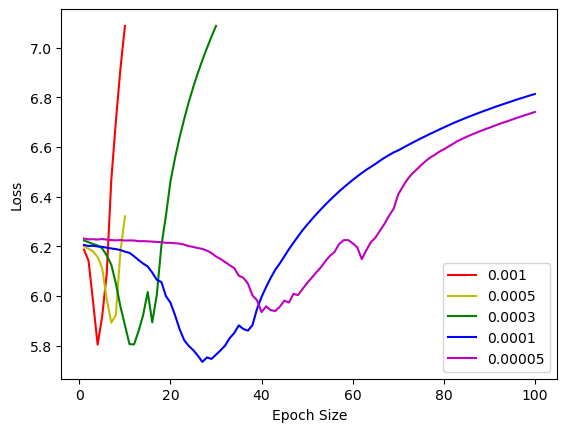

In [14]:
#Learning rate

Epoch_list_short = [x for x in range(1,11)]
Epoch_list_mid = [x for x in range(1,31)]
Epoch_list_long = [x for x in range(1,101)]
#Learning rate 0.00005
lowest_loss = [
    6.231729507446289, 6.228188991546631, 6.228956699371338, 6.227612495422363, 6.229526996612549,
    6.227306365966797, 6.225395679473877, 6.224236965179443, 6.225518226623535, 6.223486423492432,
    6.224047660827637, 6.223669052124023, 6.221007347106934, 6.221083641052246, 6.22042179107666,
    6.219142913818359, 6.218081951141357, 6.216816425323486, 6.214277267456055, 6.214404106140137,
    6.212663650512695, 6.211075782775879, 6.207221508026123, 6.201199054718018, 6.197707653045654,
    6.193297386169434, 6.189899444580078, 6.183038234710693, 6.1732587814331055, 6.159226894378662,
    6.149302959442139, 6.136756420135498, 6.124095916748047, 6.112703323364258, 6.081940174102783,
    6.073904991149902, 6.050360679626465, 6.002722263336182, 5.983165264129639, 5.935515403747559,
    5.958646297454834, 5.943641662597656, 5.939802169799805, 5.957111835479736, 5.981748104095459,
    5.973896026611328, 6.00885009765625, 6.004019260406494, 6.028904914855957, 6.052630424499512,
    6.073485851287842, 6.095391273498535, 6.115278244018555, 6.140076160430908, 6.162001609802246,
    6.177115440368652, 6.208897590637207, 6.224905490875244, 6.22553825378418, 6.212630271911621,
    6.19635009765625, 6.148804187774658, 6.184508323669434, 6.217309951782227, 6.235137462615967,
    6.263626575469971, 6.291079521179199, 6.323797702789307, 6.351808071136475, 6.4090986251831055,
    6.4409499168396, 6.469165802001953, 6.4918975830078125, 6.508532524108887, 6.526401996612549,
    6.542928695678711, 6.557346343994141, 6.568134784698486, 6.580964088439941, 6.590479373931885,
    6.601415157318115, 6.612240791320801, 6.623744487762451, 6.6322784423828125, 6.640961647033691,
    6.648881912231445, 6.656289577484131, 6.663783550262451, 6.670900344848633, 6.677488327026367,
    6.684428691864014, 6.691431045532227, 6.697839736938477, 6.703726291656494, 6.710322856903076,
    6.716891765594482, 6.722888946533203, 6.728874206542969, 6.734745979309082, 6.740909576416016
]

#Learning rate 0.0001
low_loss = batch_512 = [
    6.205747604370117, 6.201779365539551, 6.202437400817871, 6.199795246124268, 6.198395252227783,
    6.194817066192627, 6.191720962524414, 6.189075946807861, 6.185368061065674, 6.178873062133789,
    6.173830986022949, 6.160407543182373, 6.144918441772461, 6.130884170532227, 6.119250297546387,
    6.094554424285889, 6.065544605255127, 6.05655574798584, 5.9999895095825195, 5.973208904266357,
    5.9230217933654785, 5.86717414855957, 5.8229169845581055, 5.7997307777404785, 5.782531261444092,
    5.7604804039001465, 5.735124588012695, 5.753185749053955, 5.7472147941589355, 5.764242649078369,
    5.781994342803955, 5.80108118057251, 5.8308634757995605, 5.851444244384766, 5.882193088531494,
    5.86764669418335, 5.861028671264648, 5.882836818695068, 5.948583602905273, 5.99695348739624,
    6.036483287811279, 6.073141574859619, 6.105752468109131, 6.131485939025879, 6.159761905670166,
    6.188618183135986, 6.214671611785889, 6.240106582641602, 6.265035152435303, 6.287106037139893,
    6.3083038330078125, 6.328974723815918, 6.348723888397217, 6.367854595184326, 6.386116027832031,
    6.4035139083862305, 6.42072057723999, 6.436737537384033, 6.452157497406006, 6.467240333557129,
    6.4814958572387695, 6.495221138000488, 6.508294582366943, 6.520020484924316, 6.531926155090332,
    6.544775009155273, 6.5568718910217285, 6.56773567199707, 6.578110218048096, 6.586369037628174,
    6.596358776092529, 6.606138229370117, 6.615963935852051, 6.62530517578125, 6.6348795890808105,
    6.643588066101074, 6.652679443359375, 6.661296367645264, 6.670129776000977, 6.678522109985352,
    6.686741828918457, 6.695244789123535, 6.703073978424072, 6.710551738739014, 6.718006610870361,
    6.725402355194092, 6.732363224029541, 6.739287376403809, 6.746131896972656, 6.752675533294678,
    6.759415626525879, 6.765814781188965, 6.771942138671875, 6.778116226196289, 6.7842793464660645,
    6.7905802726745605, 6.796350955963135, 6.8019208908081055, 6.8077826499938965, 6.8130621910095215
]

#Learning rate 0.0003
mid_loss = [6.2239990234375,6.216647148132324,6.209654331207275,6.203518867492676,6.192065715789795,6.163589000701904,6.126288414001465,6.051880836486816,5.958495140075684,5.882617950439453,5.806708812713623,5.805641174316406,5.859466552734375,5.924002170562744,6.01662015914917,5.8942551612854,6.006546497344971,6.201990127563477,6.32350492477417,6.462177276611328,6.555911540985107,6.638702392578125,6.71204948425293,6.779936790466309,6.841231822967529,6.897190093994141,6.949131011962891,6.997842311859131,7.043798923492432,7.087125301361084]
#Learning rate 0.0005
high_loss = [6.200469017028809, 6.190797328948975,6.179993152618408,6.157564640045166,6.112344264984131,5.988590717315674,5.892480373382568,5.924180030822754,6.176090717315674,6.3208088874816895]
#Learning rate 0.001
very_high_loss = [6.186917781829834, 6.1429266929626465, 5.977673053741455, 5.804806709289551, 5.918024063110352, 6.089465141296387, 6.466081142425537, 6.701893329620361, 6.913250923156738, 7.087080955505371]

plt.plot(Epoch_list_short, very_high_loss,color='r', label='0.001')
plt.plot(Epoch_list_short, high_loss, color='y', label='0.0005') 
plt.plot(Epoch_list_mid, mid_loss, color='g', label='0.0003') 
plt.plot(Epoch_list_long, low_loss, color='b', label='0.0001') 
plt.plot(Epoch_list_long, lowest_loss, color='m', label='0.00005') 
plt.xlabel('Epoch Size')
plt.ylabel('Loss')
plt.legend()
plt.show()

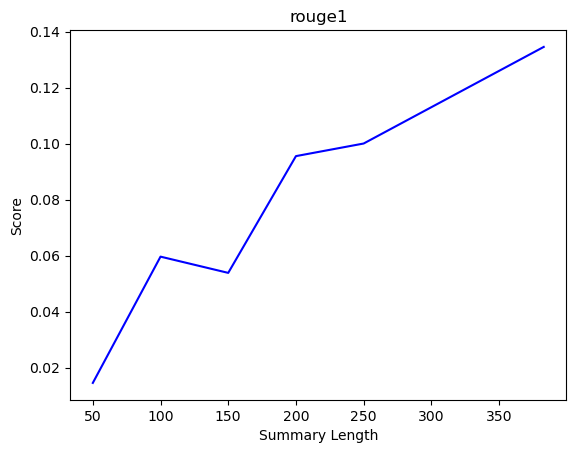

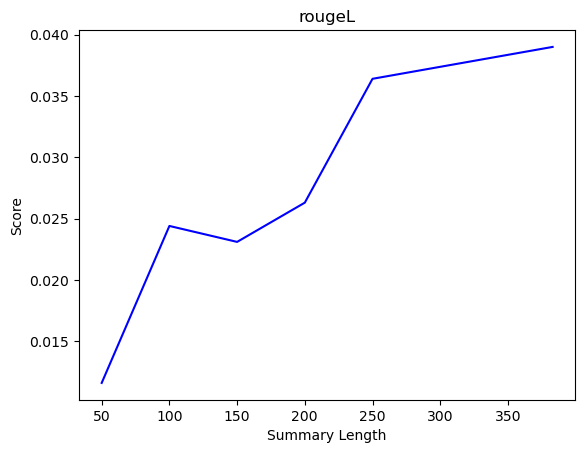

In [15]:
length = [50,100,150,200,250,383]

rouge1_f1score = [0.0145,0.0596,0.0538,0.0955,0.1000,0.1345]
rougel_f1score = [0.0116,0.02440,0.0231,0.0263,0.0364,0.0390]

plt.plot(length, rouge1_f1score, color='b', label='f1 score') 
plt.xlabel('Summary Length')
plt.ylabel('Score')
plt.title('rouge1')
plt.show()

plt.plot(length, rougel_f1score, color='b', label='f1 score') 
plt.xlabel('Summary Length')
plt.ylabel('Score')
plt.title('rougeL')
plt.show()